In [7]:
import torch
from diffsci.custom_losses import GaussianWeightedMSELoss
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# --- Case 1: 3D Data (e.g., Video or 3D Medical Scan) ---
print("\n--- Testing with 3D data (16 frames of 64x64) ---")
D, H, W = 16, 64, 64
BATCH_SIZE = 4
CHANNELS = 3

# Dummy 3D tensors
prediction_3d = torch.randn(BATCH_SIZE, CHANNELS, D, H, W, device=device)
target_3d = torch.randn(BATCH_SIZE, CHANNELS, D, H, W, device=device)

# Instantiate the loss for 3D data
loss_fn_3d = GaussianWeightedMSELoss(shape=(D, H, W), focus_radius=0.4, device=device)

# Calculate the weighted loss (before final reduction)
weighted_loss_tensor_3d = loss_fn_3d(prediction_3d, target_3d)

# Perform the final reduction to get the scalar loss value
final_loss_3d = weighted_loss_tensor_3d.mean()

print(f"Shape of the 3D weight mask: {loss_fn_3d.weight_mask.shape}")
print(f"Shape of the weighted loss tensor: {weighted_loss_tensor_3d.shape}")
print(f"Final 3D weighted loss value: {final_loss_3d.item():.4f}")


Using device: cpu

--- Testing with 3D data (16 frames of 64x64) ---
Shape of the 3D weight mask: torch.Size([1, 1, 16, 64, 64])
Shape of the weighted loss tensor: torch.Size([4, 3, 16, 64, 64])
Final 3D weighted loss value: 0.2220


In [3]:
# --- Case 2: 2D Data (e.g., Standard Image) ---
# The same class works perfectly for the original 2D use case.
print("\n--- Testing with 2D data (128x128 image) ---")
H, W = 128, 128

# Dummy 2D tensors
prediction_2d = torch.randn(BATCH_SIZE, CHANNELS, H, W, device=device)
target_2d = torch.randn(BATCH_SIZE, CHANNELS, H, W, device=device)

# Instantiate the loss for 2D data
loss_fn_2d = GaussianWeightedMSELoss(shape=(H, W), focus_radius=0.4, device=device)

# Calculate and reduce the loss
final_loss_2d = loss_fn_2d(prediction_2d, target_2d).mean()

print(f"Shape of the 2D weight mask: {loss_fn_2d.weight_mask.shape}")
print(f"Final 2D weighted loss value: {final_loss_2d.item():.4f}")



--- Testing with 2D data (128x128 image) ---
Shape of the 2D weight mask: torch.Size([1, 1, 128, 128])
Final 2D weighted loss value: 0.4835


In [ ]:
def visualize_test_case(target, prediction, weight_mask, title):
    """Helper function to plot the results of a 2D test case."""
    # Ensure tensors are on CPU and converted to numpy
    target_np = target.squeeze().cpu().numpy()
    prediction_np = prediction.squeeze().cpu().numpy()
    weight_mask_np = weight_mask.squeeze().cpu().numpy()
    
    # Calculate errors
    squared_error = (prediction_np - target_np)**2
    weighted_squared_error = squared_error * weight_mask_np
    
    fig, axes = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(title, fontsize=16)
    
    im_args = {'cmap': 'viridis', 'vmin': 0, 'vmax': 1}
    
    axes[0].imshow(target_np, **im_args)
    axes[0].set_title("Target")
    
    axes[1].imshow(prediction_np, **im_args)
    axes[1].set_title("Prediction")

    axes[2].imshow(squared_error, cmap='magma')
    axes[2].set_title("Squared Error (Unweighted)")

    im = axes[3].imshow(weight_mask_np, **im_args)
    axes[3].set_title("Gaussian Weight Mask")
    fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

    im = axes[4].imshow(weighted_squared_error, cmap='magma')
    axes[4].set_title("Weighted Squared Error")
    fig.colorbar(im, ax=axes[4], fraction=0.046, pad=0.04)
    
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def run_comparison(test_name, prediction, target, custom_loss_fn):
    """Runs a comparison, prints the results, and returns them for interpretation."""
    print(f"\n--- {test_name} ---")
    
    # Standard MSE Loss
    standard_mse_fn = nn.MSELoss()
    standard_loss = standard_mse_fn(prediction, target)
    
    # Custom Weighted Loss
    # Note: We must call .mean() here because our function returns the unreduced tensor.
    custom_loss = custom_loss_fn(prediction, target).mean()
    
    print(f"Standard MSE Loss:      {standard_loss.item():.6f}")
    print(f"Gaussian Weighted Loss: {custom_loss.item():.6f}")
    
    return custom_loss.item(), standard_loss.item()


    

Running tests on device: cpu

--- Test 1: Perfect Center, Error at Edges ---
Standard MSE Loss:      0.232742
Gaussian Weighted Loss: 0.006004
Result: Custom loss is LOWER (as expected, error is at the edges).


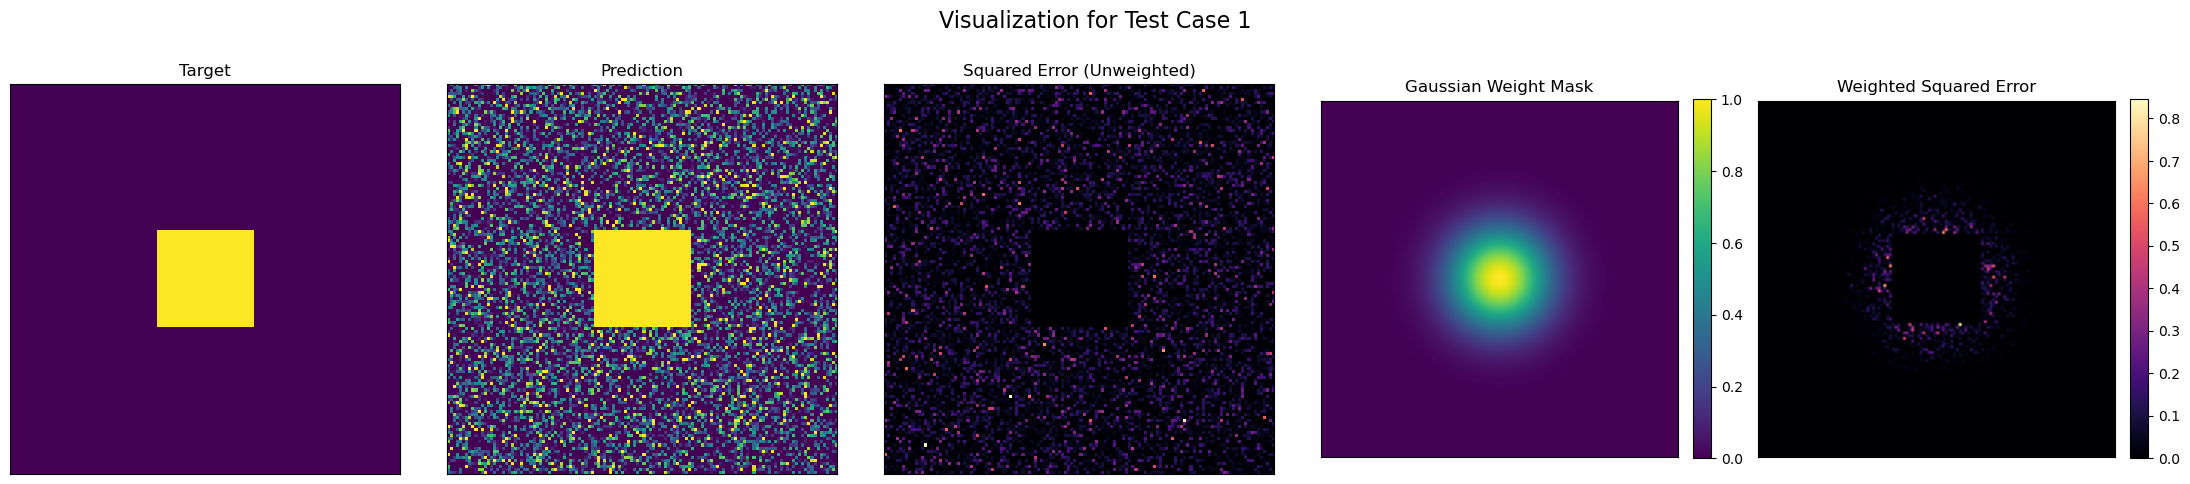


--- Test 2: Error in Center, Perfect Edges ---
Standard MSE Loss:      0.062500
Gaussian Weighted Loss: 0.038837
Result: Custom loss is LOWER (as expected, error is at the edges).


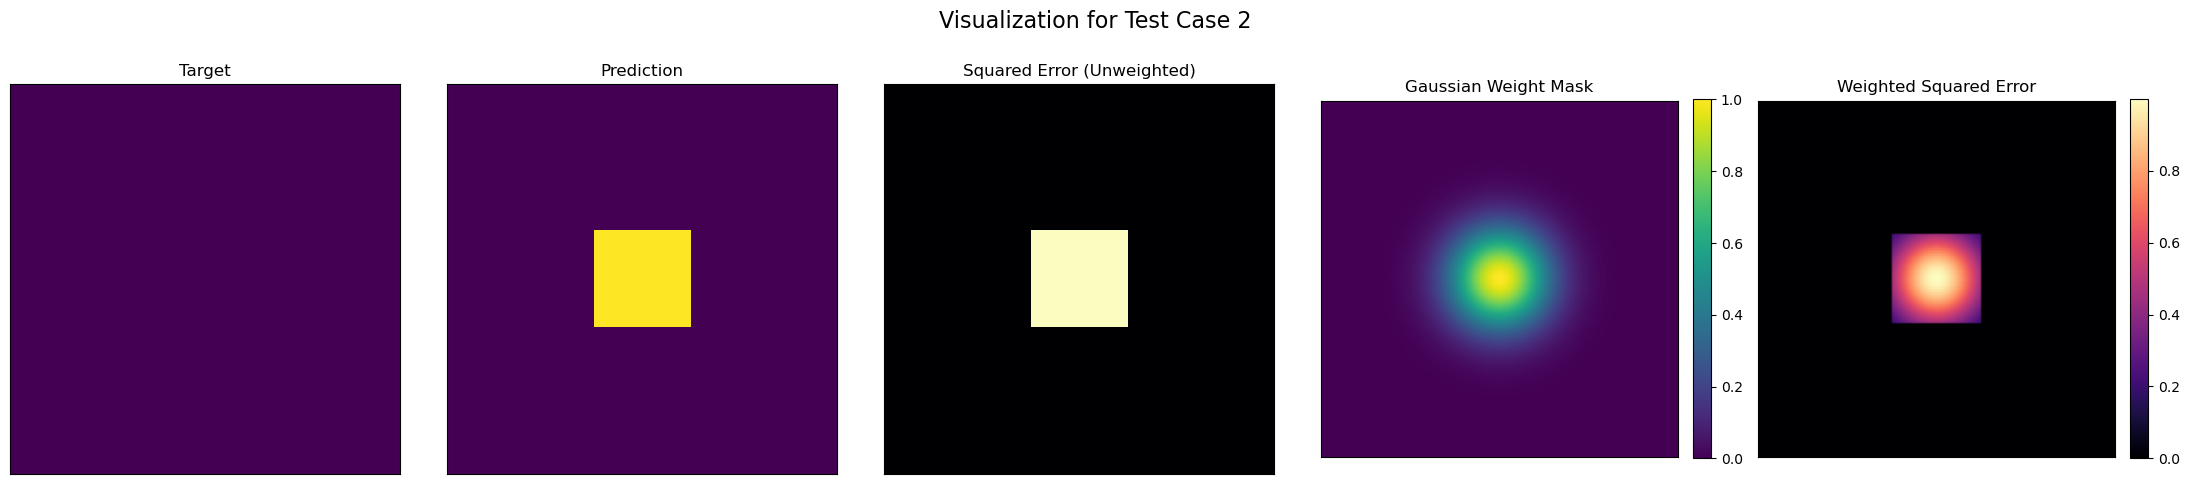


--- Test 3: 3D Error in Center ---
Standard MSE Loss:      0.062500
Gaussian Weighted Loss: 0.009431
Result: Custom loss is LOWER (as expected, error is at the edges).


(tensor(0.0094), tensor(0.0625))

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running tests on device: {device}")

# --- Test Configuration ---
H, W = 128, 128
FOCUS_RADIUS = 0.2  # A fairly sharp focus for clear results

# Instantiate our custom loss function for the tests
gaussian_loss_fn = GaussianWeightedMSELoss(shape=(H, W), focus_radius=FOCUS_RADIUS, device=device)

# --- Test Case 1: Perfect Center, Error at Edges ---
# The model gets the center right, but the periphery is wrong.
# Our custom loss should heavily discount the peripheral error.

target_center = torch.zeros(1, 1, H, W, device=device)
center_slice = slice(H//2 - 16, H//2 + 16)
target_center[:, :, center_slice, center_slice] = 1.0

# Prediction matches the center but has noise everywhere else
prediction_edges_error = target_center.clone() + torch.randn(1, 1, H, W, device=device) * 0.5
# Zero out the error in the center to make it a perfect match there
prediction_edges_error[:, :, center_slice, center_slice] = 1.0

run_comparison(
    "Test 1: Perfect Center, Error at Edges",
    prediction_edges_error,
    target_center,
    gaussian_loss_fn
)
visualize_test_case(
    target_center, 
    prediction_edges_error, 
    gaussian_loss_fn.weight_mask,
    "Visualization for Test Case 1"
)

# --- Test Case 2: Error in Center, Perfect Edges ---
# The model fails badly in the center, which is the most important region.
# Our custom loss should heavily penalize this central error.

target_zero = torch.zeros(1, 1, H, W, device=device)

# Prediction has a block of error right in the middle
prediction_center_error = torch.zeros(1, 1, H, W, device=device)
prediction_center_error[:, :, center_slice, center_slice] = 1.0

run_comparison(
    "Test 2: Error in Center, Perfect Edges",
    prediction_center_error,
    target_zero,
    gaussian_loss_fn
)
visualize_test_case(
    target_zero, 
    prediction_center_error, 
    gaussian_loss_fn.weight_mask,
    "Visualization for Test Case 2"
)

# --- Test Case 3: 3D Data Example ---
# Same as Test 2, but now the error is a "tube" through the center
# of a 3D volume (e.g., a video).

D = 32 # Depth/Time dimension

target_3d_zero = torch.zeros(1, 1, D, H, W, device=device)
prediction_3d_center_error = torch.zeros(1, 1, D, H, W, device=device)
prediction_3d_center_error[:, :, :, center_slice, center_slice] = 1.0

loss_fn_3d = GaussianWeightedMSELoss(shape=(D, H, W), focus_radius=FOCUS_RADIUS, device=device)

run_comparison(
    "Test 3: 3D Error in Center",
    prediction_3d_center_error,
    target_3d_zero,
    loss_fn_3d
)


Running tests on device: cpu

--- Test 1: Perfect Center, Error at Edges ---
Standard MSE Loss:      0.235160
Gaussian Weighted Loss: 0.215202
Result: Custom loss is LOWER (as expected, error is at the edges).
Interpretation: The error occurs at the edges where the Gaussian weights are low.
Result: The custom loss is significantly LOWER than the standard MSE. The ratio of custom/standard is 0.92, showing the error is discounted.


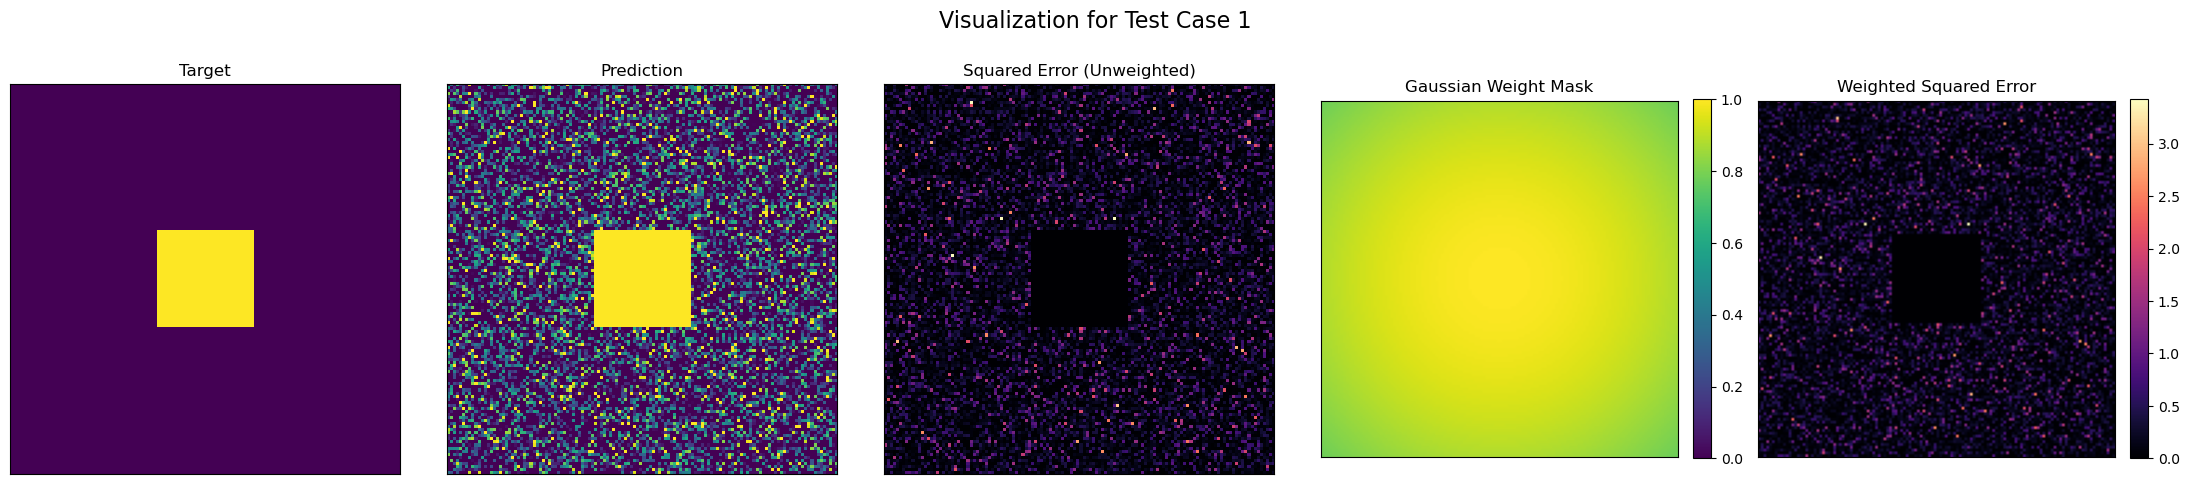


--- Test 2: Error in Center, Perfect Edges ---
Standard MSE Loss:      0.062500
Gaussian Weighted Loss: 0.062171
Result: Custom loss is LOWER (as expected, error is at the edges).
Interpretation: The error occurs in the center where the Gaussian weights are high (near 1).
Result: The custom loss is only slightly lower than the standard MSE. The ratio of custom/standard is 0.99, which is much closer to 1.0 than in Test 1. This demonstrates that the central error is penalized almost at its full value, while peripheral error is ignored.


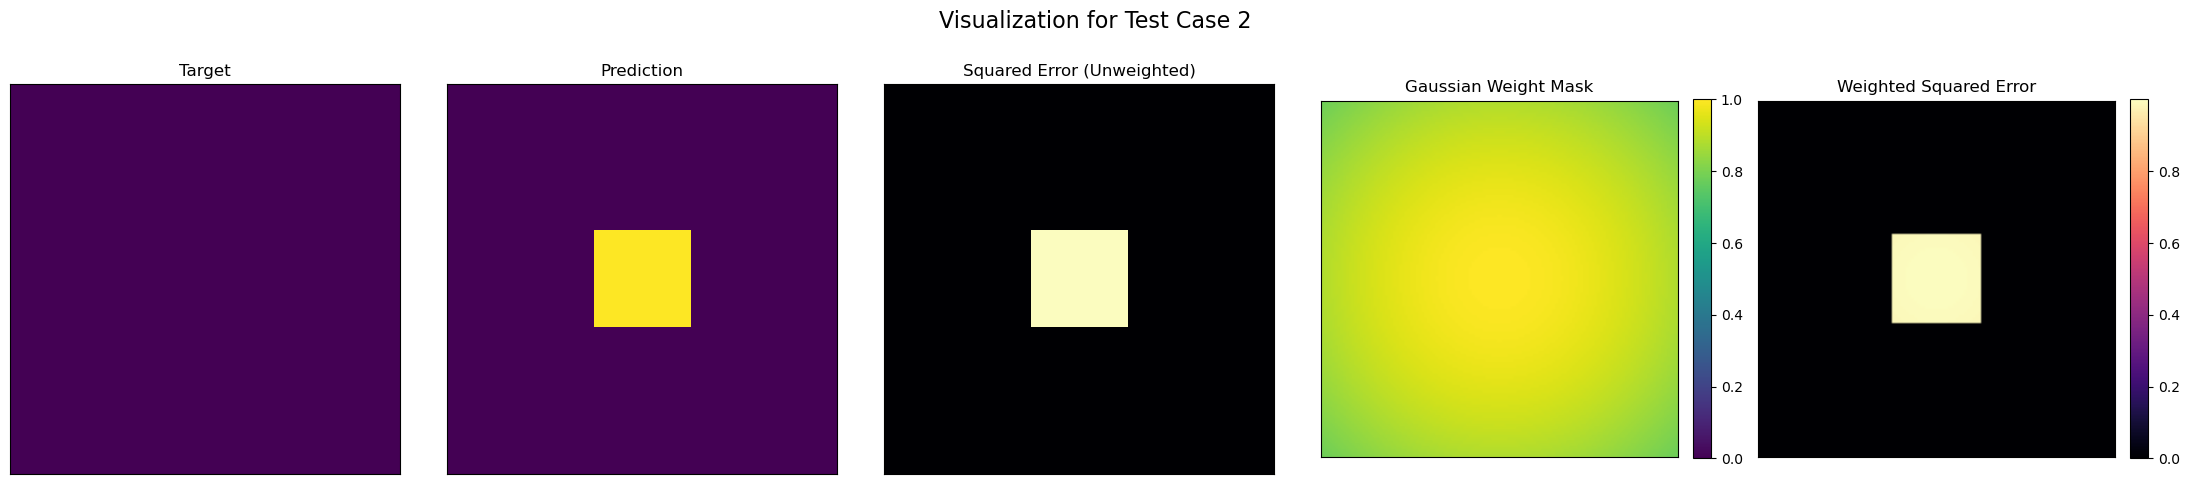


--- Test 3: 3D Error in Center ---
Standard MSE Loss:      0.062500
Gaussian Weighted Loss: 0.059520
Result: Custom loss is LOWER (as expected, error is at the edges).


(tensor(0.0595), tensor(0.0625))

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running tests on device: {device}")

# --- Test Configuration ---
H, W = 128, 128
FOCUS_RADIUS = 2  # A fairly sharp focus for clear results

# Instantiate our custom loss function for the tests
gaussian_loss_fn = GaussianWeightedMSELoss(shape=(H, W), focus_radius=FOCUS_RADIUS, device=device)

# --- Test Case 1: Perfect Center, Error at Edges ---
# The model gets the center right, but the periphery is wrong.
# Our custom loss should heavily discount the peripheral error.

target_center = torch.zeros(1, 1, H, W, device=device)
center_slice = slice(H//2 - 16, H//2 + 16)
target_center[:, :, center_slice, center_slice] = 1.0

# Prediction matches the center but has noise everywhere else
prediction_edges_error = target_center.clone() + torch.randn(1, 1, H, W, device=device) * 0.5
# Zero out the error in the center to make it a perfect match there
prediction_edges_error[:, :, center_slice, center_slice] = 1.0

custom_val_1, standard_val_1 = run_comparison(
    "Test 1: Perfect Center, Error at Edges",
    prediction_edges_error,
    target_center,
    gaussian_loss_fn
)
print("Interpretation: The error occurs at the edges where the Gaussian weights are low.")
print(f"Result: The custom loss is significantly LOWER than the standard MSE. The ratio of custom/standard is {custom_val_1 / standard_val_1:.2f}, showing the error is discounted.")

visualize_test_case(
    target_center, 
    prediction_edges_error, 
    gaussian_loss_fn.weight_mask,
    "Visualization for Test Case 1"
)

# --- Test Case 2: Error in Center, Perfect Edges ---
# The model fails badly in the center, which is the most important region.
# Our custom loss should heavily penalize this central error.

target_zero = torch.zeros(1, 1, H, W, device=device)

# Prediction has a block of error right in the middle
prediction_center_error = torch.zeros(1, 1, H, W, device=device)
prediction_center_error[:, :, center_slice, center_slice] = 1.0

custom_val_2, standard_val_2 = run_comparison(
    "Test 2: Error in Center, Perfect Edges",
    prediction_center_error,
    target_zero,
    gaussian_loss_fn
)
print("Interpretation: The error occurs in the center where the Gaussian weights are high (near 1).")
print(f"Result: The custom loss is only slightly lower than the standard MSE. The ratio of custom/standard is {custom_val_2 / standard_val_2:.2f}, which is much closer to 1.0 than in Test 1. This demonstrates that the central error is penalized almost at its full value, while peripheral error is ignored.")


visualize_test_case(
    target_zero, 
    prediction_center_error, 
    gaussian_loss_fn.weight_mask,
    "Visualization for Test Case 2"
)

# --- Test Case 3: 3D Data Example ---
# Same as Test 2, but now the error is a "tube" through the center
# of a 3D volume (e.g., a video).

D = 32 # Depth/Time dimension

target_3d_zero = torch.zeros(1, 1, D, H, W, device=device)
prediction_3d_center_error = torch.zeros(1, 1, D, H, W, device=device)
prediction_3d_center_error[:, :, :, center_slice, center_slice] = 1.0

loss_fn_3d = GaussianWeightedMSELoss(shape=(D, H, W), focus_radius=FOCUS_RADIUS, device=device)

run_comparison(
    "Test 3: 3D Error in Center",
    prediction_3d_center_error,
    target_3d_zero,
    loss_fn_3d
)
